In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2022-10-27 05:17:52--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  9.98MB/s    in 0.5s    

2022-10-27 05:17:52 (9.98 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

Load the information about the data 

In [ ]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


## Load the Ratings Data: u.data
The ratings are 100000 values from 1 - 5 for 1682 movies, with an average rating of 3.5.

In [ ]:
##item id column is renamed as movie id
column_names = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names)
ratings.head() 

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
ratings.shape

(100000, 4)

In [ ]:
n_users = len(ratings['user_id'].unique())
n_items = len(ratings['movie_id'].unique())
R_shape = (n_users, n_items)
print (str(n_users) + ' users')
print (str(n_items) + ' items')

943 users
1682 items


In [ ]:
ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
len(ratings), max(ratings['movie_id']),min(ratings['movie_id'])

(100000, 1682, 1)

## Loading the movies data : u.item
The movie IDs are ordered from 1 to 1682, with 19 genres.


In [ ]:
d = 'movie_id | title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
column_names2

['movie_id',
 'title',
 'release date',
 'video release date',
 'IMDb URL',
 'unknown',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [ ]:
movies_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
movies_dataset

,movie_id,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movies = movies_dataset[['movie_id','title']]
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
## looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column
len(movies_dataset.groupby(column_names2[1:])),len(movies_dataset)

(1664, 1682)

There are 18 extra movie IDs for movie titles that have already been mapped and the same duplicate movie ID is assigned to the user in the user-item dataset.

## Merging Ratings and Movies 

This helps to get to get all the important data in one place. Also, the same movie could have received multiple ratings from multiple users. So, merging by movie ID heps to group the same movies together. 





In [ ]:
merged_dataset = pd.merge(ratings, movies, how='inner', on='movie_id')
merged_dataset

,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)
...,...,...,...,...,...
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."


There could even be scenarios of the same user giving multiple ratings to the same movie. These need to be refined. A dataset is created from the existing merged dataset by grouping the unique user_id and movie title combination. The ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

In [ ]:
refined_dataset = merged_dataset.groupby(['user_id','movie_id', 'title'], as_index=False).agg({"rating":"mean"})

refined_dataset

,user_id,movie_id,title,rating
0,1,1,Toy Story (1995),5.0
1,1,2,GoldenEye (1995),3.0
2,1,3,Four Rooms (1995),4.0
3,1,4,Get Shorty (1995),3.0
4,1,5,Copycat (1995),3.0
...,...,...,...,...
99995,943,1067,Bottle Rocket (1996),2.0
99996,943,1074,Reality Bites (1994),4.0
99997,943,1188,Young Guns II (1990),3.0
99998,943,1228,Under Siege 2: Dark Territory (1995),3.0


# Exploratory Data Analysis

In [ ]:
num_users = len(refined_dataset['user_id'].value_counts())
num_items = len(refined_dataset['movie_id'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))

Unique number of users in the dataset: 943
Unique number of movies in the dataset: 1682


In [ ]:
rating_count = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count

,count
rating,
1.0,6110
2.0,11370
3.0,27145
4.0,34174
5.0,21201


Text(0, 0.5, 'number of ratings')

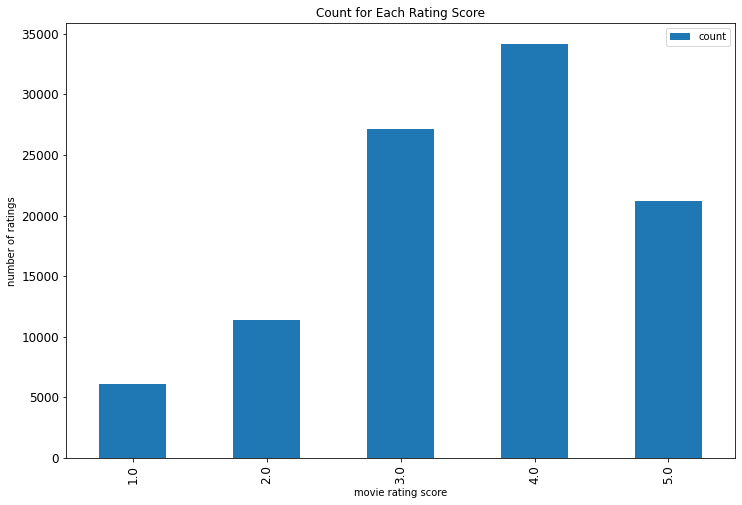

In [ ]:
ax = rating_count.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

Text(0.5, 1.0, 'Distribution of movie ratings')

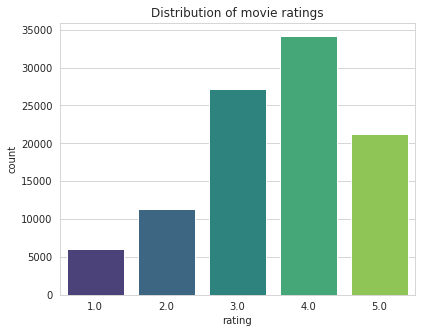

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=refined_dataset, palette="viridis")
plt.title("Distribution of movie ratings")

User_freq is a dataframe with user_id and corresponding number of movies that the user has rated.

In [ ]:
user_freq = ratings[['user_id', 'movie_id']].groupby('user_id').count().reset_index()
user_freq.columns = ['user_d', 'n_ratings']
user_freq

,user_d,n_ratings
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175
...,...,...
938,939,49
939,940,107
940,941,22
941,942,79


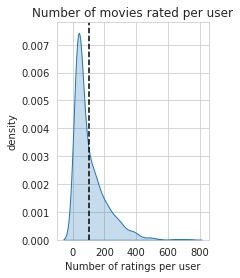

In [ ]:
#

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("Number of ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

In [ ]:
user_freq['n_ratings'].mean()

106.04453870625663

In [ ]:
#no_of_ratings_each_movie_got 
ratings_per_movie = refined_dataset.groupby('movie_id')['rating'].agg('count')
#no_of_movies_that_were_rated_by_each_user 
movies_rated_per_user = refined_dataset.groupby('user_id')['rating'].agg('count')


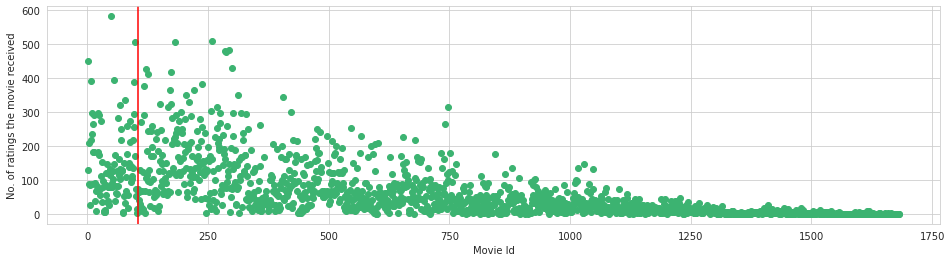

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(ratings_per_movie.index,ratings_per_movie,color='mediumseagreen')
plt.axvline(x=106,color='r')
plt.xlabel('Movie Id')
plt.ylabel('No. of ratings the movie received')
plt.show()

In [ ]:
#The index is same as the movie ID

ratings_per_movie.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682],
           dtype='int64', name='movie_id', length=1682)

In [ ]:
refined_dataset.groupby('movie_id')['rating'].agg('count')


movie_id
1       452
2       131
3        90
4       209
5        86
       ... 
1678      1
1679      1
1680      1
1681      1
1682      1
Name: rating, Length: 1682, dtype: int64

The same plot can be plotted as a line plot, and demonstrates the longtail phenomenon.

In [ ]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_dataset.groupby('movie_id').size(), columns=['count'])
movies_count_df.head()

,count
movie_id,
1,452
2,131
3,90
4,209
5,86


Text(0, 0.5, 'number of ratings')

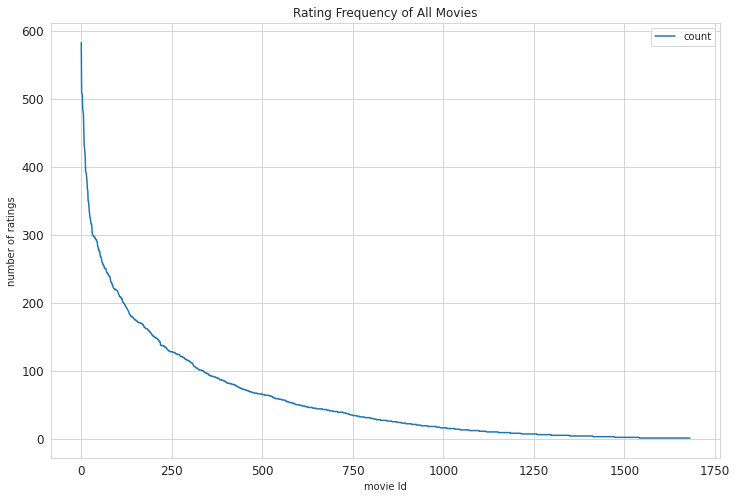

In [ ]:
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

As the size of MovieLens dataset picked for this project is small, there is no need of removing rarely rated movies or users who have given rating for fewer movies.

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

We can also plot the distribution of ratings given by each user, and it is quite apparent that each user has only rated about 20 movies.

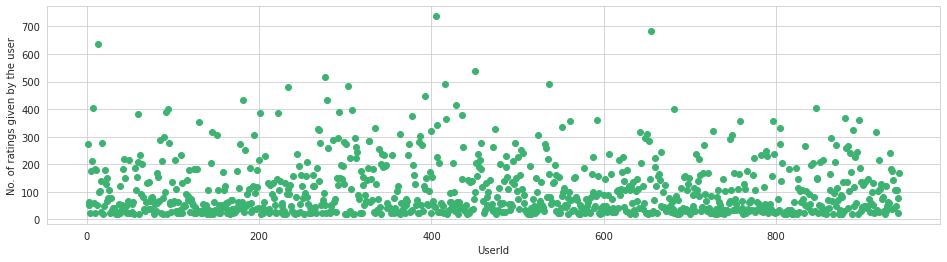

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(movies_rated_per_user.index,movies_rated_per_user,color='mediumseagreen')
plt.xlabel('UserId')
plt.ylabel('No. of ratings given by the user')
plt.show()

In [ ]:
movies_rated_per_user.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            934, 935, 936, 937, 938, 939, 940, 941, 942, 943],
           dtype='int64', name='user_id', length=943)

In [ ]:
refined_dataset.groupby('user_id')['rating'].agg('count')

user_id
1      272
2       62
3       54
4       24
5      175
      ... 
939     49
940    107
941     22
942     79
943    168
Name: rating, Length: 943, dtype: int64

Ratings for the movies not seen by a user is by default considered as 0. Let's calculate and add it to the existing dataframe.

In [ ]:
total_count = num_items * num_users
total_count


1586126

In [ ]:
refined_dataset.shape[0]

100000

In [ ]:
zero_count = total_count-refined_dataset.shape[0]
zero_count

1486126

In [ ]:
# append counts of zero rating to df_ratings_cnt
rating_count = rating_count.append(
    pd.DataFrame({'count': zero_count}, index=[0.0]),
).sort_index()
rating_count

,count
0.0,1486126
1.0,6110
2.0,11370
3.0,27145
4.0,34174
5.0,21201


Log count is taken because it is difficult to plot owing to the big difference between the values of 0 and other rating scores.

In [ ]:
# add log count
rating_count['log_count'] = np.log(rating_count['count'])
rating_count

,count,log_count
0.0,1486126,14.211683
1.0,6110,8.717682
2.0,11370,9.338734
3.0,27145,10.208948
4.0,34174,10.439220
5.0,21201,9.961804


In [ ]:
rating_count = rating_count.reset_index().rename(columns={'index': 'rating score'})
rating_count

,rating score,count,log_count
0,0.0,1486126,14.211683
1,1.0,6110,8.717682
2,2.0,11370,9.338734
3,3.0,27145,10.208948
4,4.0,34174,10.439220
5,5.0,21201,9.961804


Text(0, 0.5, 'number of ratings')

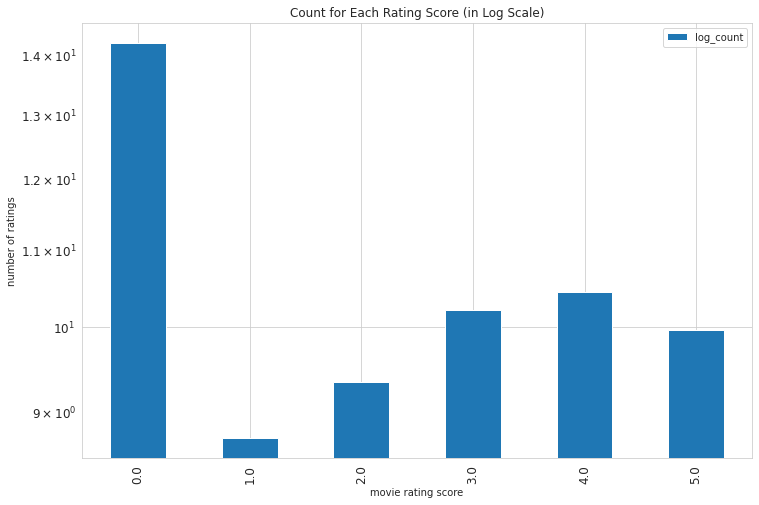

In [ ]:
ax = rating_count.plot('rating score', 'log_count', 'bar', figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

This plot gives an estimate of the sparsity in the dataframe.